In [81]:
%run runaway_functionsv3

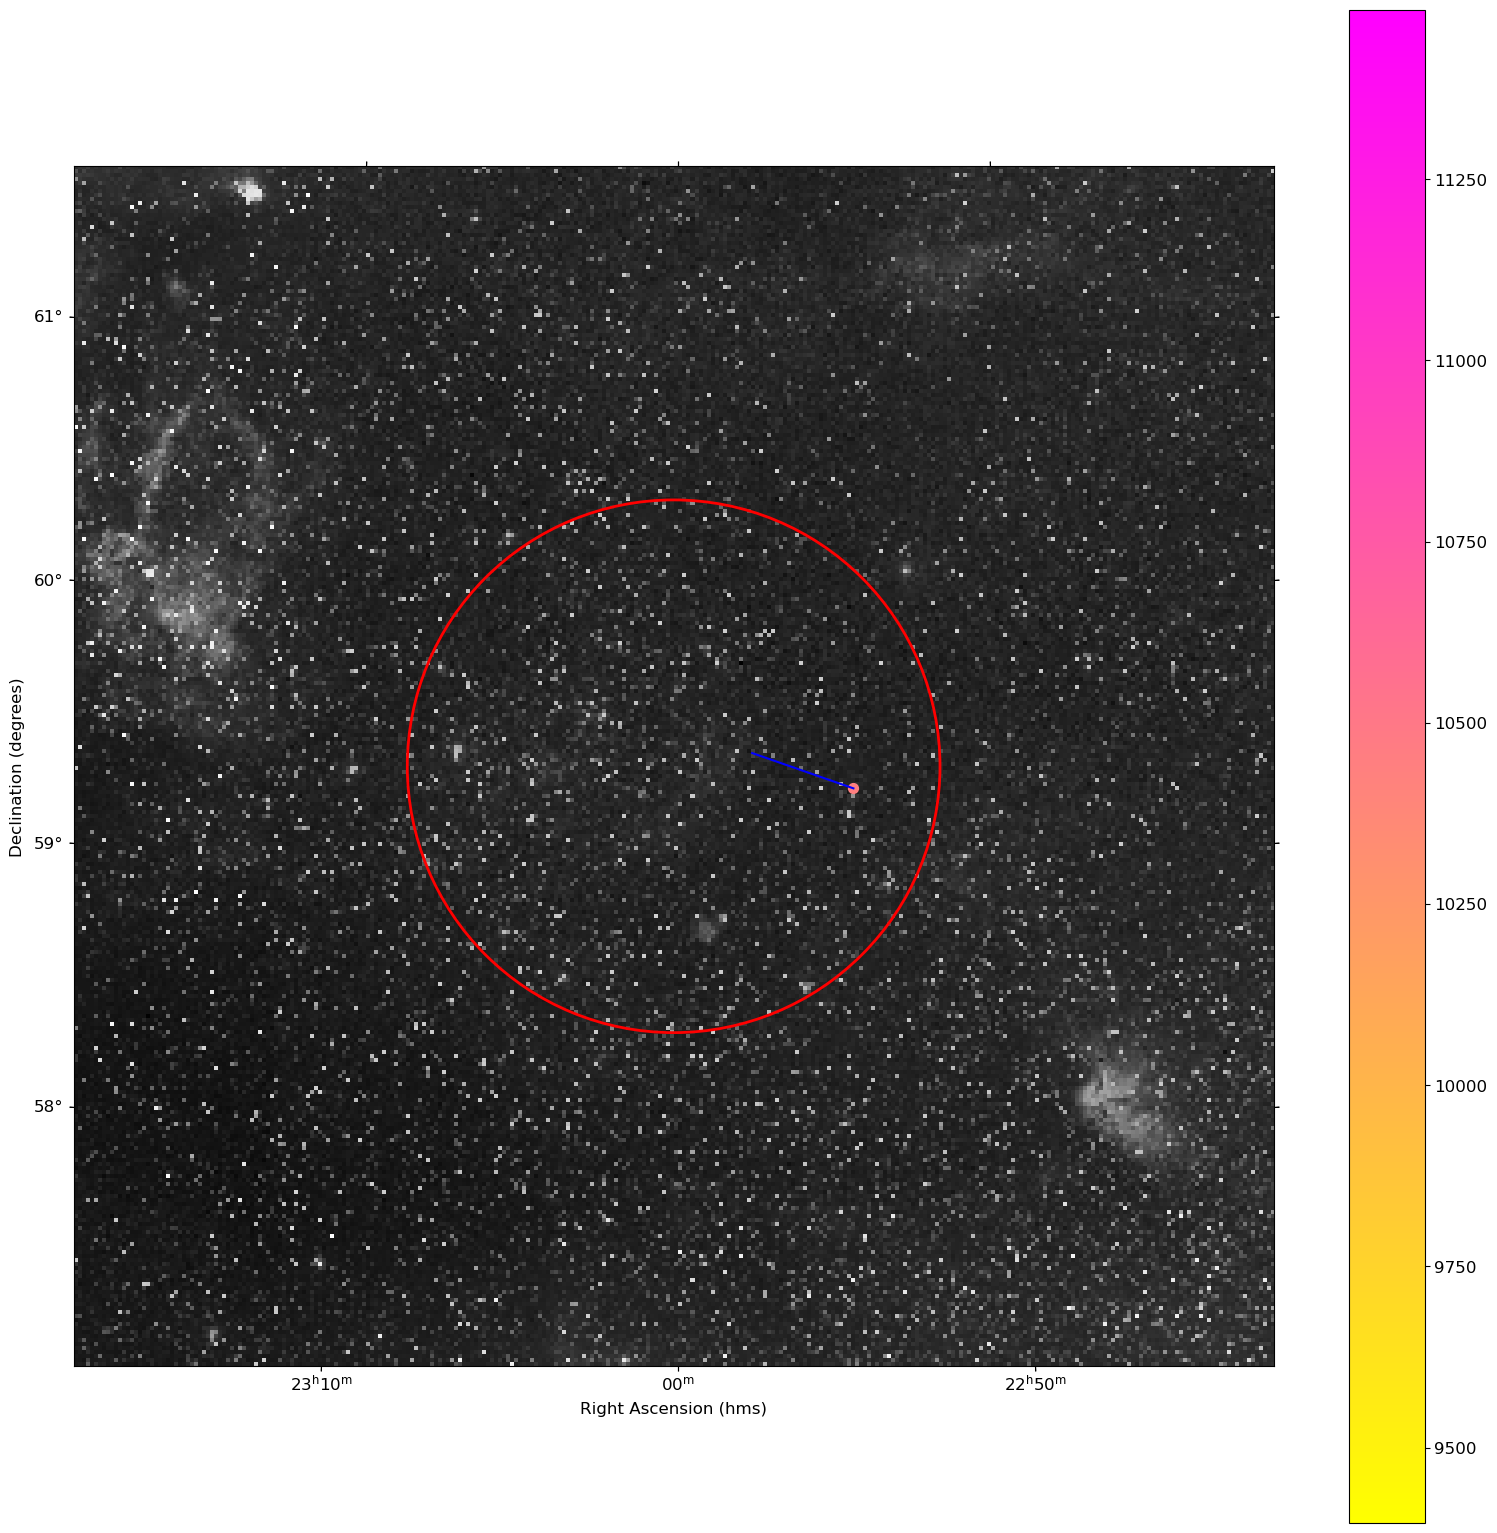

In [94]:
cl = Cluster("RSG_8")
run = cl.runaways(temp_threshold=10000)
cl.plot_traceback_clean()
# ra = cl.runaways_all()
# thiso = cl.theoretical_isochrone()
# ra['Temp. Est'] = ra["Teff"]



In [112]:
cl = Cluster("UPK_604")
# cl.plot_traceback_clean()
cl.runaways()

RA_ICRS_1,DE_ICRS_1,rgeo,Teff,Temp. Est,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Gmag,BP-RP,BPmag,RPmag,b_rgeo,B_rgeo,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,v_pec,logg,RV,e_RV,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6
deg,deg,pc,K,K,mas,mas,,,,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,mag,mag,pc,pc,,,,,"deg,deg,pc",mas / yr,mas / yr,km / s,log(cm.s**-2),km / s,km / s,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,int32,str11,int64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,SkyCoord,float64,float64,float64,float64,float64,float32,float64,float32,float32,float32,float32,float32,str1,str1
223.44181193181,-59.90927335252,694.44665500,--,13240.0,0.0063,0.0091,27.0209,--,8693-187-1,5878220441799487488,1.4144,0.0123,-6.943,-9.276,0.011,0.014,0.934,12.395457,0.655870,12.647888,11.992018,688.39233400,703.27142300,0.00276,0.002819,0.003794,0.006612,"223.44181193181,-59.90927335252,694.446655",-2.3211151771545406,-5.519692398071289,19.710132817403426,--,-6.61,11.04,207378.54267,31.87,1.192e+05,43.9,1.266e+05,38.16,--,--
223.19684926390,-60.14963911957,652.11956800,--,10490.0,0.0108,0.0140,39.3183,--,9020-1033-1,5878005998362306816,1.5093,0.0216,-18.715,-8.649,0.019,0.018,1.425,11.987373,0.754547,12.281280,11.526733,644.11315900,658.82330300,0.00276,0.002806,0.003786,0.006592,"223.1968492639,-60.14963911957,652.119568",-14.09311517715454,-4.892692398071288,46.11302388079004,--,-50.53,2.18,301993.43113,46.15,1.671e+05,45.71,1.943e+05,38.82,--,--


In [137]:
%matplotlib qt
def plot_cmd(cluster, multiple=False, **kwargs):
    #initialize plot
    fig,ax = plt.subplots(figsize=(10, 8.8))
    ax.set_xlabel(r"$G_{BP}-G_{RP}$ (mag)")
    ax.set_ylabel(r"$G$ (mag)")
    ax.set_title(f"CMD for {cluster.name}")
    lines = []
    
    #theoretical isochrone used for temperature estimate
    theoretical_isochrone = cluster.theoretical_isochrone(kwargs)
    isochrone_theo = ax.plot(theoretical_isochrone['BP-RP'], theoretical_isochrone['Gmag'], 
                              label='Dias isochrone (for Teff.)')
    #maybe add improved cluster isochrone
    ax.set_ylim(bottom= min(theoretical_isochrone['Gmag'])-4,top=18)
    ax.set_xlim(left=min(theoretical_isochrone['BP-RP'])-0.5, right=max(theoretical_isochrone['BP-RP']))
    lines.append(isochrone_theo) 
    
    #scatter cluster members
    mymembers = cluster.mymembers
    scatter_members = ax.errorbar(mymembers['BP-RP'],mymembers['Gmag'], 
                                  color='black',zorder=2,fmt='o',
                                  xerr=mymembers['e_BP-RP']+0.02,yerr=mymembers['e_Gmag'],
                 label=rf'{len(mymembers)} Cluster members')
    
    #scatter stars in the region
    stars_in_region = cluster.stars_in_region()
    scatter_sir = ax.scatter(stars_in_region['BP-RP'],stars_in_region['Gmag'],
                             s=2, color='grey',zorder=1,label=f"{len(stars_in_region)} stars in the region")
    
    #get temperature estimates for the runaways
    
    
    #scatter runaways
    runaways = cluster.runaways()
    scatter_runaways = ax.scatter(runaways['BP-RP'], runaways['Gmag'],
                                      s=30, zorder=4,
                                      c=runaways['Temp. Est'],
                                      cmap='spring_r',norm=plt.Normalize(4000, 23000),
                                      label='Runaways')

    colorbar = fig.colorbar(scatter_runaways,ax=ax)
    colorbar.set_label('Temperature (K)')
    plt.legend()
    
    # Table for cluster parameters
    cluster_table = [
        ['N',len(mymembers)],
        [r'$[Fe/H]$',cluster.FeH],
        ['log(Age)',cluster.logage],
        ['Av (mag)',round(cluster.Av.value,2)],
        ['Dist. (pc)',str(round(cluster.distance.value))+"$\pm$"+f'{cluster.all["e_Dist"]}']
    ]

    # Update Metallicity if changed
    if 'FeH' in kwargs and kwargs['FeH'] != cluster.FeH:
        cluster_table[1][1] = f'{cluster.FeH:.2f} --> {kwargs["FeH"]}'

    # Update Logage if changed
    if 'logage' in kwargs and kwargs['logage'] != cluster.logage:
        cluster_table[2][1] = f'{cluster.logage:.2f} --> {kwargs["logage"]}'

    # Update Av if changed
    if 'Av' in kwargs and kwargs['Av'] != cluster.Av:
        cluster_table[3][1] = f'{cluster.Av.value:.2f} --> {kwargs["Av"]}'


    table_bbox = [0.0, 0.84, 0.44, 0.16]  # [left, bottom, width, height]
    table = ax.table(cellText=cluster_table, cellLoc='right', loc='upper left',bbox=table_bbox)

    for key, cell in table._cells.items():
        cell.set_linewidth(0.5)  # Set the border width
        cell.set_edgecolor('lightgray')  # Set the border color
    ax.invert_yaxis()

    return None

plot_cmd(cl, Av=3)
    

In [37]:
dias2021 = Table.read("dias2021.tsv", format="ascii.ecsv")
maskplx = dias2021['Plx'] > 0.3
maskage = dias2021['logage'] < 7.7
workclusters = []
for clustername in dias2021[maskplx & maskage][:]['Cluster']:
    if clustername not in ['ASCC_79','BH_164','BH_23','Collinder_135','Collinder_140','Gulliver_9','IC_2391','IC_2602','Mamajek_1','Platais_8','UPK_535','UPK_606','UPK_640','Berkeley_59','COIN-Gaia_37','Ivanov_4','LP_1937','Sigma_Ori','UBC_632']:
        workclusters.append(clustername)
        # print(clustername)
        # cl = Cluster(clustername)
        # cl.prepare_trace()
# cl.stars_in_region()
# cl.stars_in_region()

In [ ]:
workclusters_mask = [cluster in workclusters for cluster in dias2021['Cluster']]
workclusterstable = dias2021[workclusters_mask]

rvexists = workclusterstable['RV'].mask
nrvgood = workclusterstable['NRV'] > 4

workclusterstable[~rvexists & nrvgood]

In [ ]:
def runaways_from(clustername):
    cl = Cluster(clustername)
    fs4giesler = cl.fast_stars_in_region()
    outputs = os.listdir(f"/home/surodeep/suro_aiu/traceback/cluster_runaway/{cl.name}/runaways/")
    linenos = []
    for output in outputs:
        #print(output)
        if 'run' in output:
            linenos.append(int(output.split("+")[1].replace(".out","")))
    linenos.sort()
    # print(linenos)
    i=np.array(linenos)-3
    def source_of(lineno, input_table):
        return input_table[lineno-2]['Source']
    return fs4giesler[i]
for cluster in workclusters:
    t = runaways_from(cluster)[runaways_from(cluster)['Teff'].argmax()]['Teff']
    
    if t>10000:
        print(cluster, t,runaways_from(cluster)[runaways_from(cluster)['Teff'].argmax()]['Source'])